# Model testing 

## Import libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

import cv2

import sys
sys.path.insert(0, 'C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris')
#from autotetris.dataloader import RoofDataSet
from lib.dataloader import RoofDataSet, Transforms
from lib.modeltraining import Resnet18, Resnet50, VarMSEloss, train_model, test_model

## Import path

In [2]:
path = 'C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/Dataset/data_2022-11-01/meta_data.hdf'
input_path = path

## Data Loading

In [3]:
dataset = RoofDataSet(path, transform=Transforms(new_size=(256,256)), mode = "constant")
imp_path = dataset.image_paths +  "/"+dataset.id[0]+"-b15-otovowms.jpeg"
image = cv2.imread(imp_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#%%
# split the dataset into training, validation and test sets
# Create testset
len_test_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_test_set

-------------------- Initializing dataset --------------------
--> Metadata read
--> Num_panels computed
--> Samples with many panels dropped
--> Padding samples
--> Dataset ready


## Train test split

In [4]:
train_dataset , test_dataset  = torch.utils.data.random_split(dataset, [len_train_set, len_test_set])


len_valid_set = int(0.1*len(train_dataset))
len_train_set = len(train_dataset) - len_valid_set

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [len_train_set, len_valid_set])

In [5]:
print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len_test_set))


# shuffle and batch the datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(x_.to("cpu") for x_ in default_collate(x)))
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

The length of Train set is 23971
The length of Valid set is 2663
The length of Test set is 2959


## Model Testing

In [6]:
model = Resnet50()
sys.path.insert(0, 'C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris/lib')
# path = 'trained_models/resnet18_wrap_27_11_22.pt'
path = 'C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris/trained_models/resnet50_2_diff_1_02_12_22_j.pt'
model = torch.load(path,map_location=torch.device('cpu'))
# model.load_state(torch.load('C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris/resnet18_constant_minus100_28_11_22_j.pt'))
model.eval()

Resnet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

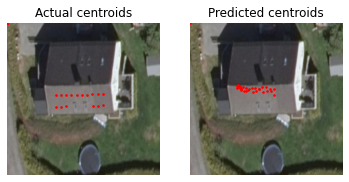

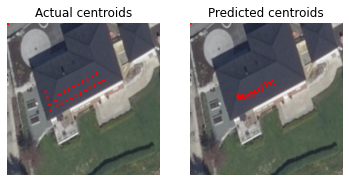

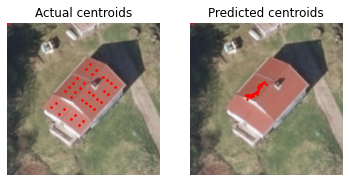

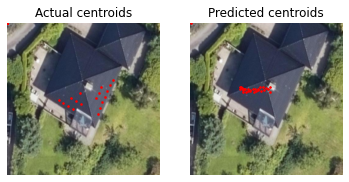

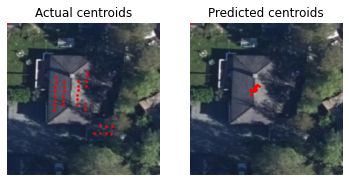

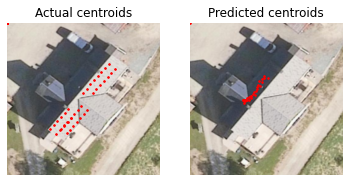

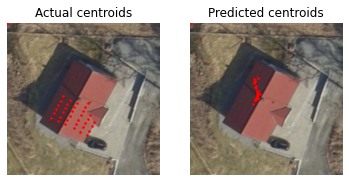

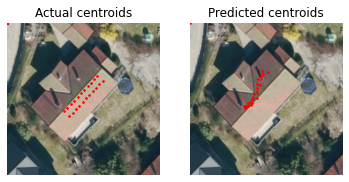

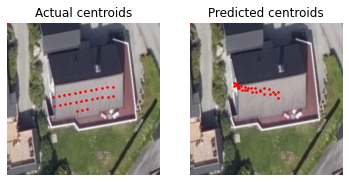

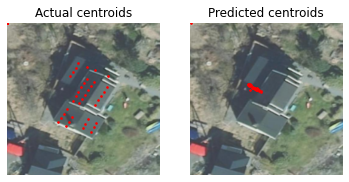

[tensor([[[120.4608, 141.0497],
          [111.4355, 140.9491],
          [114.0575, 136.3236],
          [111.5370, 133.9160],
          [114.8493, 129.0289],
          [107.8186, 128.2311],
          [115.8406, 121.7758],
          [108.0119, 121.5884],
          [111.8750, 115.7427],
          [111.8875, 116.3724],
          [113.9344, 110.9521],
          [109.8788, 109.2389],
          [115.6329, 105.1703],
          [109.5992, 104.1328],
          [112.9610,  98.0239],
          [110.6991,  98.8622],
          [114.0611,  94.4392],
          [109.5584,  94.2702],
          [114.0712,  90.1815],
          [107.7966,  88.7472],
          [111.2127,  84.7694],
          [108.8682,  83.9016],
          [109.6346,  85.3440],
          [106.1948,  83.1547],
          [109.6553,  78.9479],
          [105.9879,  79.7052],
          [108.0721,  82.4226],
          [104.9218,  80.0310],
          [113.4955,  86.0343],
          [ -0.3470,   0.6152]]], grad_fn=<ViewBackward0>),
 tensor([[[1

In [7]:
test_model(model, test_loader, 10)

## Loss plot

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
val_los = pd.read_csv('val_loss_1.csv')
train_los = pd.read_csv('train_loss_1.csv')

<AxesSubplot:>

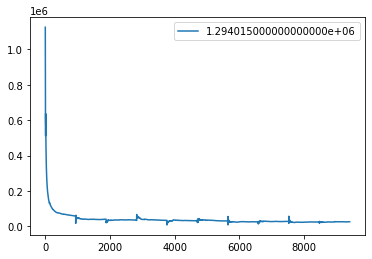

In [17]:
train_los.plot()
plt.title('Train Loss')

Text(0.5, 1.0, 'Validation Loss')

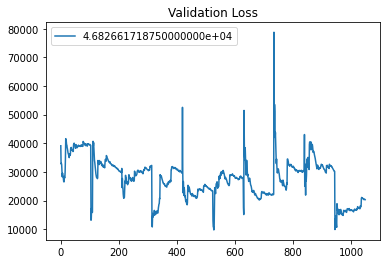

In [20]:
val_los.plot()
plt.title('Validation Loss')